DecisionTree with features [0, 1] has a score of 0.997181775481
RandomForest with 30 estimators with features [0, 1] has a score of 0.990605918271
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.997181775481
AdaBoost with 30 estimators with features [0, 1] has a score of 0.894786284641
DecisionTree with features [0, 2] has a score of 0.996712071395
RandomForest with 30 estimators with features [0, 2] has a score of 0.991075622358
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.996712071395
AdaBoost with 30 estimators with features [0, 2] has a score of 0.896665100986
DecisionTree with features [2, 3] has a score of 0.679192108971
RandomForest with 30 estimators with features [2, 3] has a score of 0.678722404885
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.679192108971
AdaBoost with 30 estimators with features [2, 3] has a score of 0.658994833255


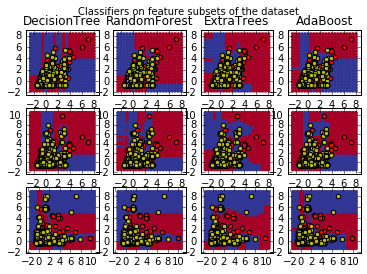

In [19]:
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import clone
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
csvreader = csv.reader(open("dataset/HEIGE.csv", newline='\n'), delimiter=';', quotechar='|')
next(csvreader) # Skip the header

data = []
target = []
for row in csvreader:
    data.append(row[2:])
    target.append(row[1])

data = np.asarray(data).astype(int)
target = np.asarray(target).astype(int)
    
plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

# We take the two features each time
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:

        X = data[:, pair]
        y = target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std
  
        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print( model_details + " with features", pair, "has a score of", scores )

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label="",
                        cmap=cmap)

        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the dataset")
plt.axis("tight")

plt.show()